In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding,CuDNNLSTM,Bidirectional, Reshape, Conv2D, MaxPool2D, Concatenate, Flatten, MaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize


In [2]:
from google.colab import drive
drive.mount('/content/drive')
nltk.download('punkt')
nltk.download('wordnet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Preprocessing (stemming, lemmatizing)

In [3]:
def preprocess_data(data, type='stem'):
  premises = []
  hypothesis = []

  if type == 'stem':
    word_stemmer = PorterStemmer()


    for sentence in data['premise']:
      tokenized_sentence = word_tokenize(sentence)
      words = []
      for word in tokenized_sentence:
        words.append(word_stemmer.stem(word))
      premises.append(' '.join(str(x) for x in words))

    for sentence in data['hypothesis']:
      tokenized_sentence = word_tokenize(sentence)
      words = []
      for word in tokenized_sentence:
        words.append(word_stemmer.stem(word))
      hypothesis.append(' '.join(str(x) for x in words))
  
  else : # lemmatize
    
    lemmatizer = WordNetLemmatizer()

    for sentence in data['premise']:
      tokenized_sentence = word_tokenize(sentence)
      words = []
      for word in tokenized_sentence:
        words.append(lemmatizer.lemmatize(word.lower()))
      premises.append(' '.join(str(x) for x in words))

    for sentence in data['hypothesis']:
      tokenized_sentence = word_tokenize(sentence)
      words = []
      for word in tokenized_sentence:
        words.append(lemmatizer.lemmatize(word.lower()))
      hypothesis.append(' '.join(str(x) for x in words))

  data['hypothesis'] = hypothesis
  data['premise'] = premises
  return data

# Data preparation


In [4]:

def label_to_one_hot(label):
  one_hot = [0, 0, 0]
  one_hot[label] = 1
  return one_hot

def prepare_data(data, preprocess=True):
  data = data[data['language']=='English']
  del data['language']
  del data['id']
  del data['lang_abv']

  if preprocess:
    data = preprocess_data(data, type='lemmatize')

  data['prem_hyp'] = data[['premise', 'hypothesis']].apply(lambda x: ' [SEP] '.join(x), axis=1)

  data['label_0'] = np.where(data['label']==0, 1, 0)
  data['label_1'] = np.where(data['label']==1, 1, 0)
  data['label_2'] = np.where(data['label']==2, 1, 0)

  x_train, x_test, _, y_test = train_test_split(data[['prem_hyp', 'label_0', 'label_1', 'label_2']], data['label'], test_size=0.3, random_state=42)

  possible_labels = ['label_0', 'label_1', 'label_2']
  targets_train = x_train[possible_labels].values

  """data["yhot"] = data["label"].apply(label_to_one_hot)
  y_train = np.zeros(shape=(len(data), 3))
  for i in range(len(data)):
      y_train[i] = data["yhot"].values[i]
  y_train = y_train.astype(int)"""
  
  return x_train, x_test, targets_train, y_test, data

def tokenize_x(x_train, x_test, modified_data, size_vector=300):
  token = Tokenizer()
  premise_hypothesis = modified_data['prem_hyp'].values
  token.fit_on_texts(premise_hypothesis)

  premise_hypothesis_train = x_train['prem_hyp'].values
  sequences_train = token.texts_to_sequences(premise_hypothesis_train)
  padding_train = pad_sequences(sequences_train,maxlen=size_vector)

  premise_hypothesis_test = x_test['prem_hyp'].values
  sequences_test = token.texts_to_sequences(premise_hypothesis_test)
  padding_test = pad_sequences(sequences_test,maxlen=size_vector)

  vocabulary_size = len(token.word_index)+1

  return token, padding_train, padding_test, vocabulary_size

def get_embedding_matrix(token, path_glove, vocabulary_size, embedding_dim = 300):
  embedding_vector = {}
  
  # get dictionnary from GloVe
  f = open (os.path.join(path_glove % embedding_dim))
  for line in tqdm(f):
      value = line.split(' ')
      word = value[0]
      coefficient = np.array(value[1:],dtype = 'float32')
      embedding_vector[word] = coefficient
  
  embedding_matrix = np.zeros((vocabulary_size,300))
  for word,i in tqdm(token.word_index.items()):
      embedding_value = embedding_vector.get(word)
      if embedding_value is not None:
          embedding_matrix[i] = embedding_value
  return embedding_matrix

# Models

## CNN


In [5]:
# Code adapted from https://www.kaggle.com/au1206/text-classification-using-cnn

def cnn_1(vocabulary_size,embedding_matrix,embedding_dim=300, size_vector=300, metric='accuracy'):
  filter_sizes = [5,50,3]
  num_filters = 10
  drop = 0.9
  batch_size = 15
  epochs = 2

  embedding_layer = Embedding(vocabulary_size,embedding_dim,weights = [embedding_matrix],input_length=size_vector,trainable = False)
  inputs = Input(shape=(300,1), dtype='int32')
  embedding = embedding_layer(inputs)
  reshape = Reshape((300,embedding_dim))(embedding)

  conv = Conv1D(num_filters, kernel_size=filter_sizes[0], padding='valid', kernel_initializer='normal', activation='relu')(reshape)
  # conv_1 = Conv1D(num_filters, kernel_size=filter_sizes[1], padding='valid', kernel_initializer='normal', activation='relu')(reshape)
  # conv_2 = Conv1D(num_filters, kernel_size=filter_sizes[2], padding='valid', kernel_initializer='normal', activation='relu')(reshape)

  maxpool = MaxPool1D(pool_size=(300 - filter_sizes[0] + 1), padding='valid')(conv)
  # maxpool_1 = MaxPool1D(pool_size=(300 - filter_sizes[1] + 1), padding='valid')(conv_1)
  # maxpool_2 = MaxPool1D(pool_size=(300 - filter_sizes[2] + 1), padding='valid')(conv_2)

  # concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
  flatten = Flatten()(maxpool)
  dropout = Dropout(drop)(flatten)
  output = Dense(units=3, activation='softmax')(dropout)
  model = Model(inputs=inputs, outputs=output)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metric])
  return model

In [10]:
def cnn_2(vocabulary_size,embedding_matrix,embedding_dim=300, metric='accuracy'):
  filter_sizes = [3,4,5]

  num_filters = 10
  drop = 0.9
  batch_size = 150
  epochs = 2

  embedding_layer = Embedding(vocabulary_size,embedding_dim,weights = [embedding_matrix],input_length=300,trainable = False)
  inputs = Input(shape=(300,), dtype='int32')
  embedding = embedding_layer(inputs)
  reshape = Reshape((300,embedding_dim,1))(embedding)
  conv = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
  # conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
  # conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

  maxpool = MaxPool2D(pool_size=(300 - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv)
  # maxpool_1 = MaxPool2D(pool_size=(300 - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
  # maxpool_2 = MaxPool2D(pool_size=(300 - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

  # concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
  flatten = Flatten()(maxpool)
  dropout = Dropout(drop)(flatten)
  output = Dense(units=3, activation='softmax')(dropout)
  model = Model(inputs=inputs, outputs=output)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metric])
  return model

## LSTM

In [22]:
from keras.layers import *
from keras.models import *
from keras import backend as K

# class from https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/
class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

def lstm(embedding_dim=300, size_vector=300, metric='accuracy'):
  """inputs = Input(shape=(size_vector,1), dtype='float32')
  embedding = Embedding(vocabulary_size,embedding_dim,weights = [embedding_matrix],input_length=300,trainable = False)(inputs)
  reshape = Reshape((300,embedding_dim,1))(embedding)
  lstm = Bidirectional(LSTM(units=64, return_sequences=True))(reshape)
  flatten = Flatten()(lstm)
  dropout = Dropout(0.3)(flatten)
  output = Dense(units=3, activation='softmax')(dropout)
  model = Model(inputs=inputs, outputs=output)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metric])"""
  model = Sequential()
  model.add(Embedding(vocabulary_size,embedding_dim,weights = [embedding_matrix],input_length=300,trainable = False))
  model.add(Bidirectional(LSTM(64)))
  model.add(Dropout(0.3))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
  return model

def lstm_attention(embedding_dim=300, size_vector=300, metric='accuracy'):
  model = Sequential()
  model.add(Embedding(vocabulary_size,embedding_dim,weights = [embedding_matrix],input_length=300,trainable = False))
  model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
  model.add(attention()) 
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy']) 
  return model

# Experiments

In [6]:
path_glove = "/content/drive/MyDrive/GloVe/glove.6B.%sd.txt"
data = pd.read_csv("/content/drive/MyDrive/dataset_watson/train.csv")
embedding_dim = 300
size_vector = 300
x_train, x_test, y_train, y_test, modified_data = prepare_data(data, True)

token, padding_train, padding_test, vocabulary_size = tokenize_x(x_train, x_test, modified_data, size_vector)

embedding_matrix = get_embedding_matrix(token, path_glove, vocabulary_size, embedding_dim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [7]:
def train_plot(x_train, y_train, model, model_name, metric="accuracy", batch_size = 64, epochs = 200):
    history = model.fit(x_train, y_train, validation_split=0.15, batch_size=batch_size, epochs=epochs, verbose=True)
    # list all data in history
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history[metric.lower()], c="blue", label="train")
    plt.plot(history.history['val_'+metric.lower()], c="orange", label="test")
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    filename = model_name + '_metric_GloVe.jpg'
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.show()
    

    # summarize history for loss
    plt.plot(history.history['loss'], c="blue", label="train")
    plt.plot(history.history['val_loss'], c="orange", label="test")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    filename = model_name + '_loss_GloVe.jpg'
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.show()

    return model, history

Epoch 1/50
64/64 [==============================] - 11s 156ms/step - loss: 1.7444 - accuracy: 0.3129 - val_loss: 1.1226 - val_accuracy: 0.2936
Epoch 2/50
64/64 [==============================] - 10s 159ms/step - loss: 1.1553 - accuracy: 0.3249 - val_loss: 1.1149 - val_accuracy: 0.3518
Epoch 3/50
64/64 [==============================] - 11s 168ms/step - loss: 1.1367 - accuracy: 0.3607 - val_loss: 1.1105 - val_accuracy: 0.3421
Epoch 4/50
64/64 [==============================] - 11s 171ms/step - loss: 1.1396 - accuracy: 0.3587 - val_loss: 1.1078 - val_accuracy: 0.3573
Epoch 5/50
64/64 [==============================] - 12s 187ms/step - loss: 1.1217 - accuracy: 0.3585 - val_loss: 1.1065 - val_accuracy: 0.3532
Epoch 6/50
64/64 [==============================] - 10s 158ms/step - loss: 1.1140 - accuracy: 0.3616 - val_loss: 1.1050 - val_accuracy: 0.3546
Epoch 7/50
64/64 [==============================] - 11s 169ms/step - loss: 1.1169 - accuracy: 0.3609 - val_loss: 1.1035 - val_accuracy: 0.3615

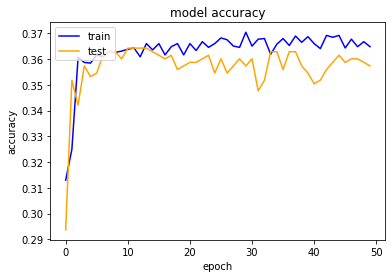

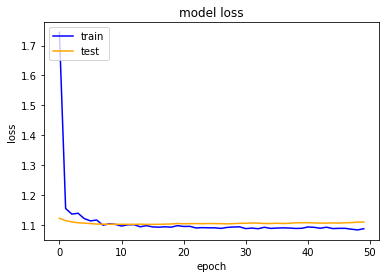

Epoch 1/50
64/64 [==============================] - 14s 210ms/step - loss: 1.4700 - auc: 0.5067 - val_loss: 1.1115 - val_auc: 0.4949
Epoch 2/50
64/64 [==============================] - 11s 175ms/step - loss: 1.1527 - auc: 0.4946 - val_loss: 1.1069 - val_auc: 0.4923
Epoch 3/50
64/64 [==============================] - 10s 162ms/step - loss: 1.1345 - auc: 0.4928 - val_loss: 1.1045 - val_auc: 0.5070
Epoch 4/50
64/64 [==============================] - 10s 150ms/step - loss: 1.1207 - auc: 0.5155 - val_loss: 1.1027 - val_auc: 0.5148
Epoch 5/50
64/64 [==============================] - 12s 182ms/step - loss: 1.1120 - auc: 0.5218 - val_loss: 1.1021 - val_auc: 0.5157
Epoch 6/50
64/64 [==============================] - 10s 164ms/step - loss: 1.1213 - auc: 0.5280 - val_loss: 1.1019 - val_auc: 0.5176
Epoch 7/50
64/64 [==============================] - 11s 172ms/step - loss: 1.1085 - auc: 0.5274 - val_loss: 1.1028 - val_auc: 0.5152
Epoch 8/50
64/64 [==============================] - 11s 174ms/step - 

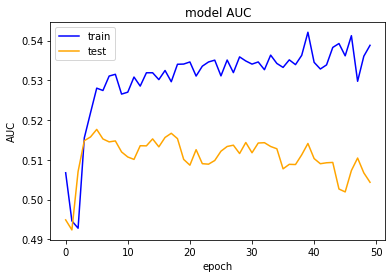

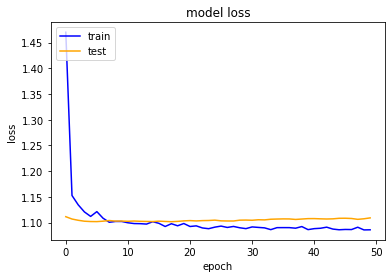

In [8]:
CNN_1D_acc = cnn_1(vocabulary_size, embedding_matrix, metric='accuracy')
model_cnn1_acc,history_cnn1_acc = train_plot(x_train=padding_train,
                           y_train=y_train,
                           model=CNN_1D_acc,
                           model_name='CNN_1D_acc',
                           metric='accuracy',
                           batch_size=64,
                           epochs=50)

CNN_1D_auc = cnn_1(vocabulary_size, embedding_matrix, metric='AUC')
model_cnn1_auc,history_cnn1_auc = train_plot(x_train=padding_train,
                           y_train=y_train,
                           model=CNN_1D_auc,
                           model_name='CNN_1D_auc',
                           metric='AUC',
                           batch_size=64,
                           epochs=50)

Epoch 1/50
64/64 [==============================] - 26s 370ms/step - loss: 1.5598 - accuracy: 0.3225 - val_loss: 1.1137 - val_accuracy: 0.3310
Epoch 2/50
64/64 [==============================] - 18s 281ms/step - loss: 1.1920 - accuracy: 0.3450 - val_loss: 1.1074 - val_accuracy: 0.3435
Epoch 3/50
64/64 [==============================] - 11s 172ms/step - loss: 1.1491 - accuracy: 0.3607 - val_loss: 1.1055 - val_accuracy: 0.3380
Epoch 4/50
64/64 [==============================] - 10s 154ms/step - loss: 1.1272 - accuracy: 0.3575 - val_loss: 1.1039 - val_accuracy: 0.3518
Epoch 5/50
64/64 [==============================] - 10s 159ms/step - loss: 1.1206 - accuracy: 0.3665 - val_loss: 1.1027 - val_accuracy: 0.3463
Epoch 6/50
64/64 [==============================] - 10s 156ms/step - loss: 1.1212 - accuracy: 0.3651 - val_loss: 1.1018 - val_accuracy: 0.3449
Epoch 7/50
64/64 [==============================] - 10s 155ms/step - loss: 1.1101 - accuracy: 0.3682 - val_loss: 1.1011 - val_accuracy: 0.3463

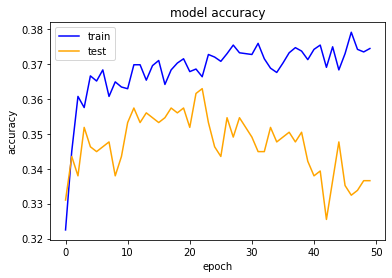

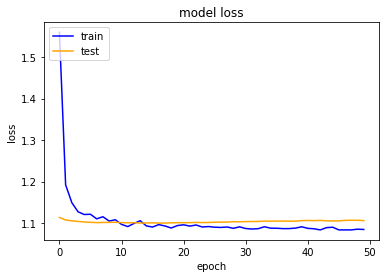

Epoch 1/50
64/64 [==============================] - 11s 160ms/step - loss: 1.5793 - auc: 0.4942 - val_loss: 1.1270 - val_auc: 0.4796
Epoch 2/50
64/64 [==============================] - 10s 151ms/step - loss: 1.1984 - auc: 0.5180 - val_loss: 1.1172 - val_auc: 0.4923
Epoch 3/50
64/64 [==============================] - 10s 158ms/step - loss: 1.1537 - auc: 0.5214 - val_loss: 1.1098 - val_auc: 0.5014
Epoch 4/50
64/64 [==============================] - 10s 156ms/step - loss: 1.1281 - auc: 0.5230 - val_loss: 1.1052 - val_auc: 0.5086
Epoch 5/50
64/64 [==============================] - 10s 153ms/step - loss: 1.1200 - auc: 0.5201 - val_loss: 1.1054 - val_auc: 0.4990
Epoch 6/50
64/64 [==============================] - 10s 164ms/step - loss: 1.1202 - auc: 0.5252 - val_loss: 1.1028 - val_auc: 0.5118
Epoch 7/50
64/64 [==============================] - 10s 154ms/step - loss: 1.1126 - auc: 0.5339 - val_loss: 1.1021 - val_auc: 0.5151
Epoch 8/50
64/64 [==============================] - 11s 165ms/step - 

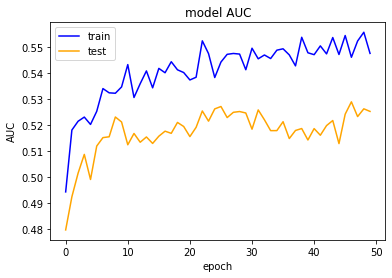

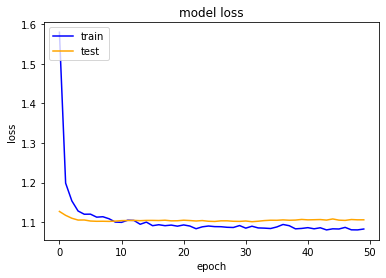

In [13]:
CNN_2D_acc = cnn_2(vocabulary_size, embedding_matrix, metric='accuracy')
model_cnn2_acc,history_cnn2_acc = train_plot(x_train=padding_train,
                           y_train=y_train,
                           model=CNN_2D_acc,
                           model_name='CNN_2D_acc',
                           metric='accuracy',
                           batch_size=64,
                           epochs=50)

CNN_2D_auc = cnn_2(vocabulary_size, embedding_matrix,metric='AUC')
model_cnn2_auc,history_cnn2_auc = train_plot(x_train=padding_train,
                           y_train=y_train,
                           model=CNN_2D_auc,
                           model_name='CNN_2D_auc',
                           metric='AUC',
                           batch_size=64,
                           epochs=50)

In [ ]:
lstm_acc = lstm(metric='accuracy')
model_cnn2_acc,history_cnn2_acc = train_plot(x_train=padding_train,
                           y_train=y_train,
                           model=lstm_acc,
                           model_name='lstm_acc',
                           metric='accuracy',
                           batch_size=64,
                           epochs=50)

lstm_auc = lstm(metric='AUC')
model_cnn2_auc,history_cnn2_auc = train_plot(x_train=padding_train,
                           y_train=y_train,
                           model=lstm_auc,
                           model_name='lstm_auc',
                           metric='AUC',
                           batch_size=64,
                           epochs=50)

Epoch 1/50
17/64 [======>.......................] - ETA: 34s - loss: 1.1113 - categorical_accuracy: 0.3355

In [ ]:
lstm_att_acc = lstm('accuracy')
model_cnn2_acc,history_cnn2_acc = train_plot(x_train=padding_train,
                           y_train=y_train,
                           model=lstm_att_acc,
                           model_name='lstm_att_acc',
                           metric='accuracy',
                           batch_size=64,
                           epochs=50)

lstm_att_auc = lstm('AUC')
model_cnn2_auc,history_cnn2_auc = train_plot(x_train=padding_train,
                           y_train=y_train,
                           model=lstm_att_auc,
                           model_name='lstm_att_auc',
                           metric='AUC',
                           batch_size=64,
                           epochs=50)